# Graphs Extraction - MPL 512 * 256 * 128

## Set Up

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import re
import json
import pandas as pd
from pathlib import Path

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.saving import load_model

import sys
# Add the workspace root to sys.path so 'scripts' can be imported
sys.path.append(str(Path.cwd().parents[3]))

from scripts.feature_extractions.graphs_stat import get_graphs_stat_from_files


2025-07-17 15:24:23.471154: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
PATH = Path.cwd().parents[3]
MODEL_PATH = os.path.join(PATH, 'models/baseline')
DATA_PATH = os.path.join(PATH, 'data')
EX_PATH = os.path.join(DATA_PATH, 'external/crpwarner/large')
HEX_PATH = os.path.join(EX_PATH, 'hex')
name = 'graphs_stat'

### Load Model

In [4]:
model_paths = list(Path(MODEL_PATH).glob(f'{name}-f1-*.keras'))
best_thresholds_paths = list(Path(MODEL_PATH).glob(f'best_thresholds_for_{name}-f1-*.json'))

In [5]:
def get_best_model_path(paths):
    best_f1_score = -1.0
    best_path = None

    for path in paths:
        # Extract the F1 score using a regular expression
        match = re.search(r'f1-(\d+\.\d+)\.(pkl|json|keras)$', path.name)
        if match:
            try:
                f1_score = float(match.group(1))
                if f1_score > best_f1_score:
                    best_f1_score = f1_score
                    best_path = path
            except ValueError:
                # Handle cases where the extracted string might not be a valid float
                print(f"Warning: Could not parse F1 score from filename: {path.name}")
        else:
            print(f"Warning: F1 score pattern not found in filename: {path.name}")

    return best_path

In [6]:
best_model_path = get_best_model_path(model_paths)

if best_model_path:
    model = load_model(best_model_path)

In [7]:
best_thresholds_path = get_best_model_path(best_thresholds_paths)

if best_thresholds_path:
    with open(best_thresholds_path, 'r') as file:
        best_thresholds = json.load(file)['thresholds']

In [8]:
best_thresholds

[0.42, 0.47000000000000003, 0.56]

In [9]:
with open(os.path.join(DATA_PATH, f'processed/{name}/features.json'), 'r', encoding='utf-8') as f:
    train_cols = json.load(f)

In [10]:
train_cols

['num_nodes',
 'num_edges',
 'avg_degree',
 'density',
 'connected_components',
 'avg_clustering']

## Mint

### Load and Prepare Data

In [11]:
df = pd.read_excel(os.path.join(EX_PATH, 'sample/mint.xlsx'))
df['Address'] = df['Address'].str.lower()
df = df.set_index('Address')
df.head()

,TP?
Address,
0x0fef20d2c4ee011fa0389e69e9fa92a2291b63c8,Yes
0xd7cc0deb9dd11be95068bf2d7a3d082b8ba9bf04,Yes
0xa1b756be589441519b1a08e16bc4f60ab177d916,Yes
0x514bc174df04a4b04ae2be81ee8c788c3796b06b,Yes
0x1354c8c1a66c2573ce9cc3e92e98d17869501a46,Yes


In [12]:
df.isna().sum()

TP?    0
dtype: int64

In [13]:
files = []
y = []

for path in list(Path(HEX_PATH).glob('*.hex')):
    address = path.stem.lower()
    if address in df.index:
        files.append(path)
        tp_value = df.loc[address, 'TP?']
        if isinstance(tp_value, pd.Series):
            tp_value = tp_value.iloc[0]
        y.append(1 if tp_value == 'Yes' else 0)

X = get_graphs_stat_from_files(files)

100%|██████████| 92/92 [00:13<00:00,  7.07it/s]


In [14]:
X

,num_nodes,num_edges,avg_degree,density,connected_components,avg_clustering
address,,,,,,
0x71a982a028c9d4b0566041a78df12b810462e155,205,163,1.590244,0.003898,53,0.000000
0x8d3bd2940bbc5ed724d138934374e4c0ad3c0027,244,162,1.327869,0.002732,90,0.006148
0x4c0c2052dfdb2d0932644f7b2d4bea509678b9d9,300,237,1.580000,0.002642,81,0.024444
0x0d42fb07a685d2ff9d6bb93df0389946192cd322,362,247,1.364641,0.001890,122,0.020258
0x7dd2f15b4a8c8e14da5eaa7b635221d4b39c41cc,117,94,1.606838,0.006926,26,0.032764
...,...,...,...,...,...,...
0x7e9d5e7655bf3ee30043ca24a55eb6f799e0ee54,177,137,1.548023,0.004398,47,0.000000
0x03260e1b0f53e1a1f93cf126a7ca42a1c71648d6,155,126,1.625806,0.005279,36,0.000000
0xfdf475788c31c57e85f2c48add16164fb5ac84e3,178,159,1.786517,0.005047,30,0.000000


In [15]:
y[:5]

[1, 1, 1, 1, 1]

In [16]:
X = X.reindex(columns=train_cols, fill_value=0).reset_index(drop=True)

### Evaluate

In [17]:
y_prob = model.predict(X)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [18]:
y_prob

array([[0.49699885, 0.3868098 , 0.5587881 ],
       [0.50853115, 0.412714  , 0.54610044],
       [0.5086703 , 0.40780494, 0.62085915],
       [0.62226254, 0.43420663, 0.6155338 ],
       [0.45612773, 0.34423172, 0.59711045],
       [0.5408884 , 0.4336552 , 0.53172994],
       [0.54112333, 0.39344501, 0.5337516 ],
       [0.48180413, 0.34730718, 0.5578864 ],
       [0.47102812, 0.3618751 , 0.5602683 ],
       [0.48593244, 0.3717836 , 0.55518043],
       [0.5013721 , 0.36229274, 0.5827954 ],
       [0.6770405 , 0.51936007, 0.7403275 ],
       [0.55702   , 0.44102097, 0.5452126 ],
       [0.45428637, 0.34611562, 0.57701844],
       [0.45408037, 0.3497036 , 0.6033884 ],
       [0.4857032 , 0.42720214, 0.70357287],
       [0.62088   , 0.42827588, 0.6040295 ],
       [0.56186205, 0.45182812, 0.66665685],
       [0.43823874, 0.35012934, 0.64990544],
       [0.45935878, 0.36621213, 0.56670123],
       [0.4594932 , 0.3498275 , 0.6148859 ],
       [0.598123  , 0.4475887 , 0.6519691 ],
       [0.

In [19]:
y_pred = (y_prob >= best_thresholds).astype(int)

In [20]:
y_pred[1]

array([1, 0, 0])

In [21]:
y_pred[:, 0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [22]:
y_pred = y_pred[:, 0]

In [23]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [24]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.85      1.00      0.92        78

    accuracy                           0.85        92
   macro avg       0.42      0.50      0.46        92
weighted avg       0.72      0.85      0.78        92



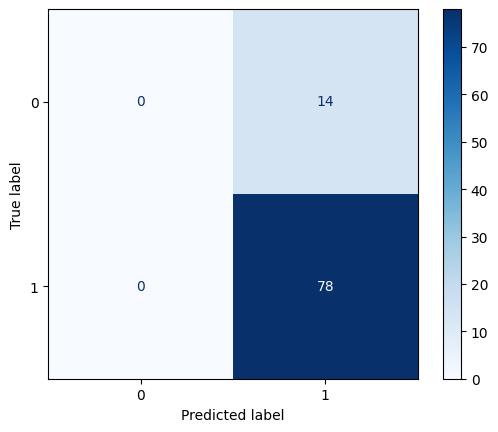

In [25]:
cm = confusion_matrix(y, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

## Leak

### Load and Prepare Data

In [26]:
df = pd.read_excel(os.path.join(EX_PATH, 'sample/leak.xlsx'))
df['Address'] = df['Address'].str.lower()
df = df.set_index('Address')
df.head()

,TP?
Address,
0x0290ea3c728981725689187763f6c63a68e192b8,Yes
0x054ad3cd4a66f14bf5c0de2548a53be66995a4f6,Yes
0x0566c17dc2a9efcaa2f63e04cf06a69e8fc77f60,No
0x10c8324b20b7266c445944f043f53f6a77ea0bd4,Yes
0x10cc060f6f9b2e5dcdb23f1361e4b368a7daec73,Yes


In [27]:
df.isna().sum()

TP?    0
dtype: int64

In [28]:
files = []
y = []

for path in list(Path(HEX_PATH).glob('*.hex')):
    address = path.stem.lower()
    if address in df.index:
        files.append(path)
        tp_value = df.loc[address, 'TP?']
        if isinstance(tp_value, pd.Series):
            tp_value = tp_value.iloc[0]
        y.append(1 if tp_value == 'Yes' else 0)

X = get_graphs_stat_from_files(files)

100%|██████████| 87/87 [00:41<00:00,  2.09it/s]


In [29]:
X

,num_nodes,num_edges,avg_degree,density,connected_components,avg_clustering
address,,,,,,
0xf6962cfe3b9618374097d51bc6691efb3974d06f,346,262,1.514451,0.002195,96,0.017823
0x666c549f5a01167f1aa19bb68be552441f520895,177,184,2.079096,0.005907,13,0.106403
0x76bc9e61a1904b82cbf70d1fd9c0f8a120483bbb,150,105,1.400000,0.004698,60,0.041111
0x10cc060f6f9b2e5dcdb23f1361e4b368a7daec73,489,415,1.697342,0.001739,81,0.006135
0xa99f34b4672ff3a9837fd93dea375ccfbb83c89a,299,235,1.571906,0.002637,72,0.007804
...,...,...,...,...,...,...
0x8a52499ff8c65cedd4d7ccc283a0dab6df285fe2,312,241,1.544872,0.002484,89,0.000000
0x6b9ee9e79bb893d394da79e2ea51685d1855318e,248,120,0.967742,0.001959,135,0.000000
0xdf482745749ad7057f4ebe246975ff2f2ddeef78,178,157,1.764045,0.004983,32,0.000000


In [30]:
y[:5]

[1, 1, 1, 1, 0]

In [31]:
X = X.reindex(columns=train_cols, fill_value=0).reset_index(drop=True)

### Evaluate

In [32]:
y_prob = model.predict(X)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [33]:
y_prob

array([[0.5735617 , 0.4292408 , 0.6360943 ],
       [0.48503527, 0.3664505 , 0.5706605 ],
       [0.44782493, 0.34495866, 0.5853323 ],
       [0.708103  , 0.5210568 , 0.7191293 ],
       [0.55955726, 0.44096154, 0.5748175 ],
       [0.53204393, 0.41418904, 0.5232832 ],
       [0.5167107 , 0.39612624, 0.53969544],
       [0.81427604, 0.5014439 , 0.7458242 ],
       [0.48168677, 0.3840078 , 0.55067104],
       [0.47825855, 0.3686617 , 0.5636318 ],
       [0.5501483 , 0.435734  , 0.71202445],
       [0.4529857 , 0.34789437, 0.5931828 ],
       [0.5568447 , 0.37594673, 0.5761709 ],
       [0.51932865, 0.38054168, 0.49938548],
       [0.53204393, 0.41418904, 0.5232832 ],
       [0.47422758, 0.387152  , 0.57024145],
       [0.50035053, 0.37078276, 0.5413456 ],
       [0.49954635, 0.35657454, 0.5340518 ],
       [0.5321527 , 0.42326835, 0.53376955],
       [0.49273136, 0.36368746, 0.5429732 ],
       [0.5522454 , 0.44437996, 0.54846925],
       [0.70277065, 0.4799679 , 0.7051189 ],
       [0.

In [34]:
y_pred = (y_prob >= best_thresholds).astype(int)

In [35]:
y_pred[1]

array([1, 0, 1])

In [36]:
y_pred[:, 1]

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [37]:
y_pred = y_pred[:, 1]

In [38]:
y_pred

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [39]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.17      1.00      0.29        13
           1       1.00      0.12      0.22        74

    accuracy                           0.25        87
   macro avg       0.58      0.56      0.25        87
weighted avg       0.88      0.25      0.23        87



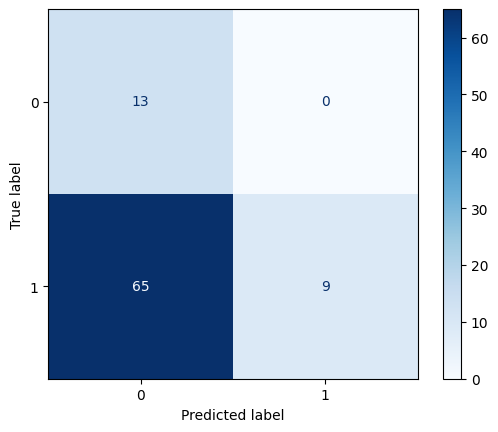

In [40]:
cm = confusion_matrix(y, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

## Limit

### Load and Prepare Data

In [41]:
df = pd.read_excel(os.path.join(EX_PATH, 'sample/limit.xlsx'))
df['Address'] = df['Address'].str.lower()
df = df.set_index('Address')
df.head()

,TP?
Address,
0xe5f3c6d2b47cbe2cf936b9521466bac2422ebef8,Yes
0xa623b5a542c0d7daadef321042a04c600b03a8cb,Yes
0xe412189da2dfa188a1a61633114b8732bbbfba19,Yes
0x9fcf7acdc11fd904c4b73a009909c7f00efc4844,Yes
0x921a5dce3dfed5cccfbb2e593f2978533bc66110,Yes


In [42]:
df.isna().sum()

TP?    0
dtype: int64

In [43]:
files = []
y = []

for path in list(Path(HEX_PATH).glob('*.hex')):
    address = path.stem.lower()
    if address in df.index:
        files.append(path)
        tp_value = df.loc[address, 'TP?']
        if isinstance(tp_value, pd.Series):
            tp_value = tp_value.iloc[0]
        y.append(1 if tp_value == 'Yes' else 0)

X = get_graphs_stat_from_files(files)

100%|██████████| 91/91 [00:16<00:00,  5.41it/s]


In [44]:
X

,num_nodes,num_edges,avg_degree,density,connected_components,avg_clustering
address,,,,,,
0x1f4a9567c1f98a8c9d7f026827f099b41a2e54d6,194,163,1.680412,0.004353,42,0.060137
0x76bc9e61a1904b82cbf70d1fd9c0f8a120483bbb,150,105,1.400000,0.004698,60,0.041111
0xa5d77efbc45d574b689d7f1202cf817e23febb97,179,159,1.776536,0.004990,31,0.000000
0xb08fc1db58ef5e15a6f97d8f63b2bb4a14b9df37,68,64,1.882353,0.014047,10,0.100490
0x40165bd6d657b63cb6f8f4a3525ac05bbf74bd93,285,209,1.466667,0.002582,82,0.000000
...,...,...,...,...,...,...
0x4c567c3363cc42c5a42c6d8bf01503fd1d0b91cd,199,150,1.507538,0.003807,52,0.000000
0x3fb1926a7d1cc68d4166d99c3483465885074f2f,167,132,1.580838,0.004762,44,0.000000
0xfb5fb992b64c86fbcb33ba151abd8ecbcc611bde,219,191,1.744292,0.004001,40,0.006849


In [45]:
y[:5]

[1, 1, 1, 0, 1]

In [46]:
X = X.reindex(columns=train_cols, fill_value=0).reset_index(drop=True)

### Evaluate

In [47]:
y_prob = model.predict(X)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [48]:
y_prob

array([[0.5002585 , 0.38014632, 0.54881185],
       [0.44782493, 0.34495866, 0.5853323 ],
       [0.5001286 , 0.37112406, 0.54208755],
       [0.48333287, 0.3623236 , 0.6774767 ],
       [0.56262314, 0.442583  , 0.55353516],
       [0.5102963 , 0.37209454, 0.52308476],
       [0.53445613, 0.42074922, 0.52557003],
       [0.44000646, 0.45150316, 0.69312835],
       [0.46336293, 0.34629592, 0.57306457],
       [0.5273837 , 0.37298372, 0.5070972 ],
       [0.5645037 , 0.39066997, 0.6000173 ],
       [0.46713123, 0.36726803, 0.56125075],
       [0.5001286 , 0.37112406, 0.54208755],
       [0.5092824 , 0.38557446, 0.53659284],
       [0.45318794, 0.3530929 , 0.6016581 ],
       [0.5564864 , 0.44344264, 0.5141059 ],
       [0.47599477, 0.35345587, 0.5597231 ],
       [0.5860708 , 0.42391595, 0.6098952 ],
       [0.4463517 , 0.36792538, 0.5918951 ],
       [0.5168839 , 0.4170371 , 0.54955035],
       [0.4528447 , 0.34587196, 0.5822133 ],
       [0.50525856, 0.39445755, 0.55408555],
       [0.

In [49]:
y_pred = (y_prob >= best_thresholds).astype(int)

In [50]:
y_pred[1]

array([1, 0, 1])

In [51]:
y_pred[:, 2]

array([0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 1])

In [52]:
y_pred = y_pred[:, 2]

In [53]:
y_pred

array([0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 1])

In [54]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.07      0.23      0.11        13
           1       0.80      0.50      0.61        78

    accuracy                           0.46        91
   macro avg       0.43      0.37      0.36        91
weighted avg       0.69      0.46      0.54        91



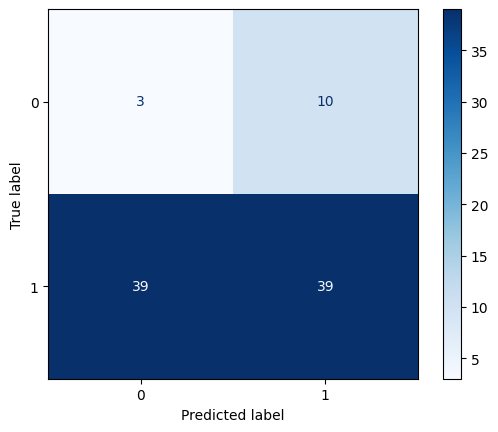

In [55]:
cm = confusion_matrix(y, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()